# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 7: Generative Models - Variational Autoencoders and GANs [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- For this homework **you do NOT need to restart the kernel and run the whole notebook again before you submit**.
- **You should SAVE your models, and do not retrain on notebook reruns**.
- In this homework we import general keras library objects. Feel free to experiment and use different layers, optimizers, random initializers... whater you like using from the core libraries we import.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

---

<div class="theme"> Overview </div> 

We are going to compare autoencoders (AEs), variational autoencoders (VAEs) and generative adversarial networks (GANs). The goal is to understand the particularities of each model and to learn how to build them. 

In addition to standard VAEs, we will also study conditional VAEs. Conditional VAEs incorporate input attributes on the latent representation of an input, providing some structure in the latent space. We will analyze how conditioal VAEs are capable of generating new photos according that depend on specified attributes. 

We are going to train our networks using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is a large-scale face attributes dataset with more than 200K celebrity images and 40 different attribute annotations.

Run the following cell to load important libraries.

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

**Check availability of GPU**

Run this line to verify your instance is lists an available GPU.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

**Dowload CelebA Dataset**

Make sure to have `tensorflow_datasets` installed on version 2.1.0 before running following cell. You can install by running the following code on a **terminal** (not from Jupyter):

```pip install tensorflow_datasets==2.1.0```

Download CelebA if you have not downloaded it already. You can use the following line to download manually from a **terminal**:

```wget https://cs109b2020.s3.amazonaws.com/2.0.0.zip```

Uncompress it under ```~/tensorflow_datasets/celeb_a/2.0.0/```.


In [4]:
# Run this cell
# Assumes CelebA has been manually downloaded and is available in `~/tensorflow_datasets/celeb_a/2.0.0/`.

import tensorflow_datasets as tfds

train_celeb, val_celeb = tfds.load('celeb_a', split=['train', 'validation'], shuffle_files=False, download=False)

In [5]:
# Global variables to define training/loading models. 
# Modify as required. These are only suggested parameters.

train = True
epochs = 5  # number of epochs to train models
batch_size = 32
input_size = (64, 64, 3)  # images will be cropped and resized to `input_size`.

---

## <div class='exercise'><b>Question 1: Preprocess and visualize the data [20 pts]</b></div>

CelebA has 202,599 face images of various celebrities and training on the whole set requires large computational resources to fit your models. For this reason we recommend cropping the images and resizing them to reduce to computational costs. Feel free to adjust the images resolution depending on your computation capabilities. We recommend using `image_size = (64,64,3)`, but feel free to use a larger resolution, or smaller, up to `image_size = (32,32,3)`. 

We provide the function `tf_norm_crop_resize_image` to normalize image pixels between `[0,1]`, to crop the height and width of images to `150x150` pixels, and to [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) images to the indicated size in the function call. Follow the intructions below to format your data for the different models you will need to train:

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

In [6]:
# DO NOT DELETE THIS CELL
# Use this function to normalize, crop and resize your images.
def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

## Answers

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

In [7]:
# 1.1
# your code here
def tf_norm_crop_resize_image_helper(elem):
    image = elem['image']
    elem['image'] = tf_norm_crop_resize_image(image, (input_size[0],input_size[1]))
    return (elem['image'],elem['image'])
val_ds = val_celeb.map(tf_norm_crop_resize_image_helper).shuffle(100).batch(batch_size)
train_ds = train_celeb.map(tf_norm_crop_resize_image_helper).shuffle(100).batch(batch_size)

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

In [8]:
# 1.2
def tf_norm_crop_resize_image_helper_with_atributes(elem):
    image = elem['image']
    attributes  = {}
    elem['image'] = tf_norm_crop_resize_image(image, (input_size[0],input_size[1]))
    attributes['Bald'] = elem['attributes']['Bald']
    attributes['Goatee'] = elem['attributes']['Goatee']
    tf.dtypes.cast(attributes['Bald'], tf.float32)
    print(tf.dtypes.cast(attributes['Bald'], tf.float32))
    return ((elem['image'],[tf.dtypes.cast(attributes['Goatee'], tf.float32),tf.dtypes.cast(attributes['Bald'], tf.float32)]),elem['image'])
val_cond_ds = val_celeb.map(tf_norm_crop_resize_image_helper_with_atributes).shuffle(100).batch(batch_size)
train_cond_ds = train_celeb.map(tf_norm_crop_resize_image_helper_with_atributes).shuffle(100).batch(batch_size)

Tensor("Cast_2:0", shape=(), dtype=float32)
Tensor("Cast_2:0", shape=(), dtype=float32)


**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

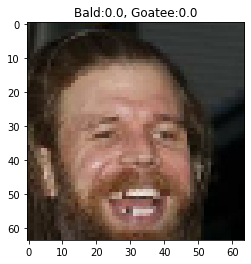

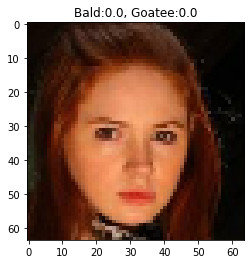

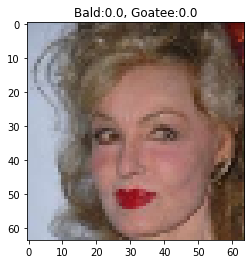

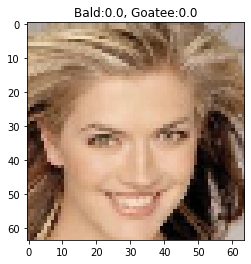

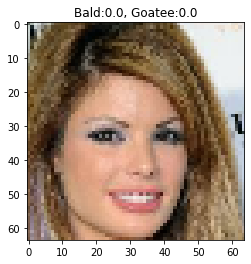

In [9]:
# 1.3
images = train_cond_ds.take(1)
for test_img in images:
    ((image,attributes), image2) = test_img
    bald = attributes[:,1]
    goatee=attributes[:,0]
    for i in range(5):
        print()
        fig, ax = plt.subplots()
        ax.imshow(image[i,:,:,:])
        ax.set_title("Bald:"+str(bald[i].numpy())+", Goatee:"+str(goatee[i].numpy()))



---

<div class='exercise'> <b> Question 2: Set-up an AutoEncoder [20 points] </b> </div>

**Define custom convolutional layers**

We provide below the skeleton of a custom keras layer that you need to complete to build the following models. You should read the Keras [guidelines](https://www.tensorflow.org/guide/keras/custom_layers_and_models) on how to build custom layers. You are required to fill the specific methods indicated below on each part.

You will then construct an autoencoder using both custom layers, and visualize the AE image reconstruction and latent spaces.

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

**We recommend [saving](https://www.tensorflow.org/tutorials/keras/save_and_load) the trained model**.

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

## Answers

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

In [10]:
# 2.1

class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_size, **kwargs)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=9, kernel_size=(5, 5), input_shape=input_shape, strides=(2,2),padding="same", activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.conv2 = tf.keras.layers.Conv2D(filters=18, kernel_size=(5, 5),strides=(2,2),padding="same", activation="relu")
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5),strides=(2,2),padding="same", activation="relu")
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),strides=(2,2),padding="same", activation="relu")
        self.dropout4 = tf.keras.layers.Dropout(dropout_rate)
        
        ## your code here
        
        # end of your code here
        

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.dropout3(x)
        x = self.conv4(x)
        x = self.dropout4(x)
        return x
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        # end of your code here


**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

In [11]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """
    def __init__(self, input_shape, dropout_rate=0.5, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        self.dropout_rate = dropout_rate

        self.deconv1 = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=(2,2),
                       activation='relu',input_shape=input_shape)
        
        self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
        self.deconv2 = tf.keras.layers.Conv2DTranspose(18, (5,5), padding='same', strides=(2,2),
                       activation='tanh')
        self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
        self.deconv3 = tf.keras.layers.Conv2DTranspose(9, (5,5), padding='same', strides=(2,2),
                       activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
        
        self.deconv4 = tf.keras.layers.Conv2DTranspose(3, (5,5), padding='same', strides=(2,2),
                       activation='sigmoid')
        
        # end of your code here
        
    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here

        x = self.deconv1(inputs)
        x = self.dropout1(x)
        x = self.deconv2(x)
        x = self.dropout2(x)
        x = self.deconv3(x)
        x = self.dropout3(x)
        x = self.deconv4(x)

        # end your code here
        return x

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

In [12]:
# 2.3
input_layer = tf.keras.layers.Input(shape=(input_size))
encoder = ConvEncoder(name="Encoder", input_shape=input_size)(input_layer)
flatten = tf.keras.layers.Flatten()(encoder)
dense_linear = tf.keras.layers.Dense(128, activation='linear')(flatten)
dense_relu = tf.keras.layers.Dense(1024, activation='relu')(dense_linear)
reshape = tf.keras.layers.Reshape((4, 4, 64), input_shape=(1024,))(dense_relu)
deconv = ConvDecoder(name="Decoder", input_shape=(4, 4, 64))(reshape)

AE = tf.keras.Model(input_layer, deconv)
AE.compile(optimizer='Adam', loss='mean_squared_error') 
AE.summary()


# inputs = tf.keras.layers.InputLayer(input_size)                 # input layer
# encoder = (inputs)
# flatten = tf.keras.layers.Flatten()(encoder)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
Encoder (ConvEncoder)        (None, 4, 4, 64)          70448     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
Decoder (ConvDecoder)        (None, 64, 64, 3)         70387 

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

Having a linear activation in the bottleneck is a necessary element, as it allows the Encoding to be fully expressed within the bottleneck space. IF we were to use an activation function like relu or sigmoid, we are arbitrarily limiting value of a particular weight, and determining the degree to which weights are distributed in that space. By using a linear activation, we make sure we are taking full advantage of the whole bottleneck space and not filling our space with 0's or values very close to 0 and 1.

In doing so, we allow our AutoEncoder to learn more complex information about the image, and thus output an imate that is more nuanced than simply a blurrier version of our original

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

In [13]:
# 2.5
AE.fit(
    train_ds,
    epochs=3, validation_data=val_ds)

Epoch 1/3
    798/Unknown - 33s 41ms/step - loss: 0.0299

KeyboardInterrupt: 

In [ ]:
AE.save_weights('AE')



In [14]:
AE.load_weights('AE')


**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

(32, 64, 64, 3)


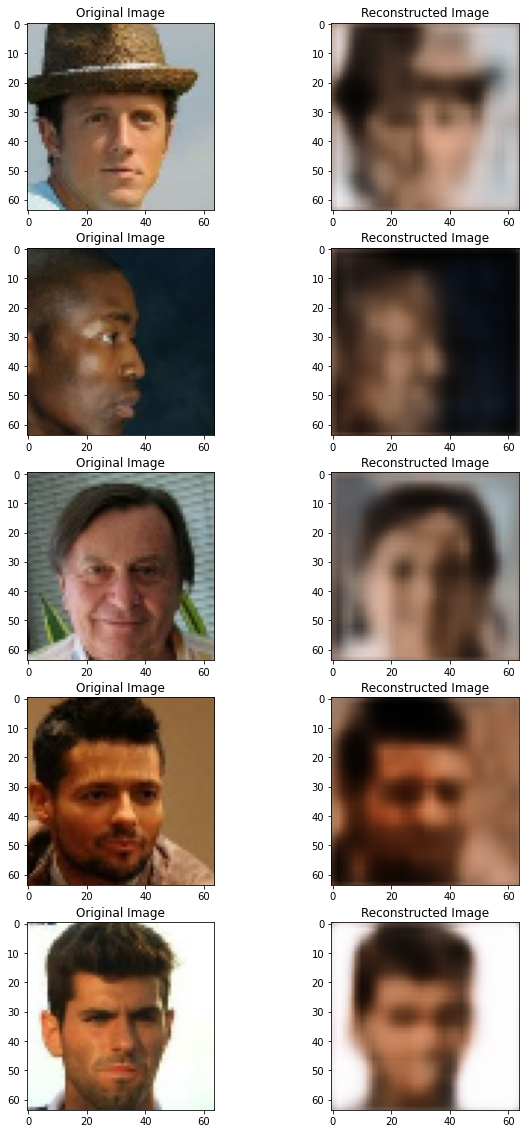

In [15]:
# 2.6
fig, ax = plt.subplots(5,2,figsize=(10,20))
test_pics = val_ds.take(1)
for pic in test_pics:
    (image, image2) = pic
    predicted = AE.predict(image)
    for i in range(5):
        ax[i,0].imshow(image[i,:,:])
        ax[i,0].set_title("Original Image")
        ax[i,1].imshow(predicted[i,:,:])
        ax[i,1].set_title("Reconstructed Image")
    print(image.shape)
#     ax[i,0].imshow(test_pics[i,:,:])
# 
# 
# 

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

In [16]:
# Extracing from bottleneck layer
import seaborn as sns

bottleneck = AE.layers[3].output
bottleneck_model = tf.keras.Model(input_layer, outputs=bottleneck)
pca_images = None
labels = []
for image_group in val_cond_ds.take(32):
    ((image,attributes), image2) = image_group
    bald = attributes[:,1]
    goatee=attributes[:,0]
    for i in range (image.shape[0]):
        labels.append(int(np.sum((2*goatee[i].numpy(), bald[i].numpy()))))
    if pca_images is None:
        pca_images = image
    else:
        pca_images = np.append(pca_images, image, axis=0)
        
bottleneck_output = bottleneck_model.predict(pca_images)

In [17]:
labels = np.array(labels)

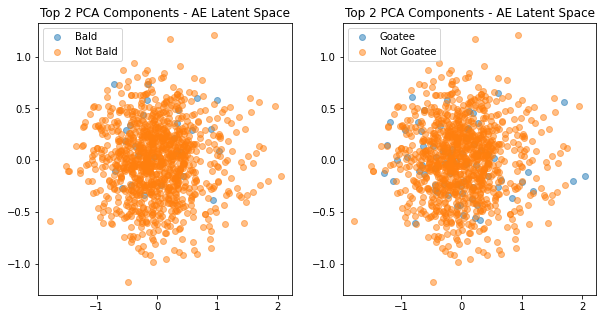

In [18]:
# 2.7 (PCA visualization)
# your code here
flattened_output = bottleneck_output.reshape(bottleneck_output.shape[0], -1) 
num_components = 2
flattened_output
pca = PCA(n_components=num_components).fit_transform(flattened_output)
fig, ax = plt.subplots(1,2, figsize=(10,5))
none = np.argwhere(labels==0)
bald = np.argwhere(labels==1)
goatee = np.argwhere(labels==2)
both = np.argwhere(labels==3)
all_bald = np.append(bald,both)
not_bald = np.append(goatee, none)
all_goatee = np.append(goatee,both)
not_goatee = np.append(bald, none)

ax[0].scatter(x=pca[all_bald,0], y=pca[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=pca[not_bald,0], y=pca[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("Top 2 PCA Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=pca[all_goatee,0], y=pca[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=pca[not_goatee,0], y=pca[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("Top 2 PCA Components - AE Latent Space")
ax[1].legend()


PCA does not show a ton of good clustering here, and the latent representation of images with the features I chose similarly does not exhibit any distinct cluster. Perhaps this is strictly because the latent representation of being bald and having a goatee are not major component to the overall latent space representation.

I am, however, a bit surprised by the lack of clusters. I'd think that some major traits (race, gender, hair color) would result in clear clusters in the latent space. This is, however, not the case.

Compute also the t-SNE decomposition of the latent images. Does it uncover any characteristic structure? Please, explain your answer

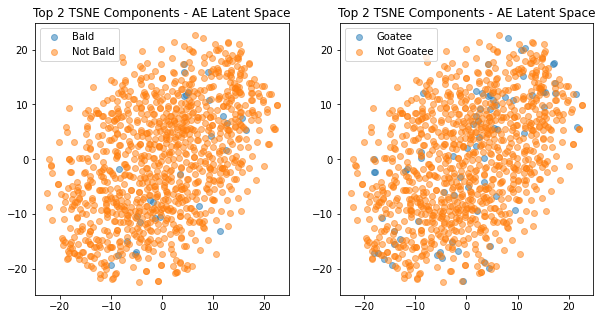

In [19]:
# 2.7 (t-SNE visualization)
# your code here
num_components = 2
tsne = X_embedded = TSNE(n_components=num_components).fit_transform(flattened_output)
fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].scatter(x=tsne[all_bald,0], y=tsne[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=tsne[not_bald,0], y=tsne[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("Top 2 TSNE Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=tsne[all_goatee,0], y=tsne[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=tsne[not_goatee,0], y=tsne[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("Top 2 TSNE Components - AE Latent Space")

ax[1].legend()



TSNE similarly does not yield meaningful clusters and information latent-space representation of the data. Again, I'd guess this is because my attributes do not contribute meaningfully to the latent representation of a face.

---

<div class='exercise'> <b> Question 3: Set-up a Convolutional Variational Autoencoder [20 points].</b> </div>

In this exercise you will code a standard Variational Autoencoder. You will first create a custom layer `Sampling` that takes the mean and log-variance of a Gaussian distribution as inputs, and returns a sample from that distribution. You will use this sample as a latent representation of your probabilistic encoder conditioned on the input image, and use it to reconstruct an image. You will build the complete VAE architecture and study its properties.

You will need to minimize the negative ELBO function formed by a reconstruction loss and a regularization term over the mean and variance of the probabilistic encoder. You will train two VAE models, one with no regularization, and a second with regularization.

Follow these instructions:

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

## Answers

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

In [20]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean an d 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        (z_mean, z_log_var) = inputs
        self.z_mean = z_mean
        self_z_log_var = z_log_var
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], 128))
        z = z_mean + tf.keras.backend.exp(z_log_var) * epsilon
        return z
        
        # your code here
        




**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

In [21]:
# 3.2 
input_layer = tf.keras.layers.Input(shape=(input_size))
encoder = ConvEncoder(name="Encoder", input_shape=input_size)(input_layer)
flatten = tf.keras.layers.Flatten()(encoder)
dense_mean = tf.keras.layers.Dense(128, activation='linear')(flatten)
dense_variance = tf.keras.layers.Dense(128, activation='linear')(flatten)
sampling = Sampling()((dense_mean, dense_variance))
dense_relu = tf.keras.layers.Dense(1024, activation='relu')(sampling)
reshape = tf.keras.layers.Reshape((4, 4, 64), input_shape=(1024,))(dense_relu)
deconv = ConvDecoder(name="Decoder", input_shape=(4, 4, 64))(reshape)

VAE1 = tf.keras.Model(input_layer, deconv)
VAE1.compile(optimizer='Adam', loss='mean_squared_error') 
VAE1.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (ConvEncoder)           (None, 4, 4, 64)     70448       input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1024)         0           Encoder[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          131200      flatten_1[0][0]                  
____________________________________________________________________________________________

In [22]:
# 3.2 
input_layer = tf.keras.layers.Input(shape=(input_size))
encoder = ConvEncoder(name="Encoder", input_shape=input_size)(input_layer)
flatten = tf.keras.layers.Flatten()(encoder)
dense_mean = tf.keras.layers.Dense(128, activation='linear')(flatten)
dense_variance = tf.keras.layers.Dense(128, activation='linear')(flatten)
sampling = Sampling()((dense_mean, dense_variance))
dense_relu = tf.keras.layers.Dense(1024, activation='relu')(sampling)
reshape = tf.keras.layers.Reshape((4, 4, 64), input_shape=(1024,))(dense_relu)
deconv = ConvDecoder(name="Decoder", input_shape=(4, 4, 64))(reshape)
kl_loss = - 0.0001 * 0.5 * tf.reduce_mean(dense_variance - tf.square(dense_mean) - tf.exp(dense_variance) + 1)

VAE2 = tf.keras.Model(input_layer, deconv)
VAE2.add_loss(kl_loss)
VAE2.compile(optimizer='adam', loss='mean_squared_error' )
VAE2.summary()




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (ConvEncoder)           (None, 4, 4, 64)     70448       input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 1024)         0           Encoder[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          131200      flatten_2[0][0]                  
____________________________________________________________________________________________

In [23]:
# Fit Models
VAE1.fit(
    train_ds,
    epochs=5, validation_data=val_ds)




Epoch 1/5
    176/Unknown - 8s 46ms/step - loss: 0.0558

KeyboardInterrupt: 

In [ ]:
# Fit Models
VAE2.fit(
    train_ds,
    epochs=5, validation_data=val_ds)


In [ ]:
VAE1.save_weights('VAE1')
VAE2.save_weights('VAE2')

In [24]:
VAE1.load_weights('VAE1')
VAE2.load_weights('VAE2')

VAE2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (ConvEncoder)           (None, 4, 4, 64)     70448       input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 1024)         0           Encoder[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          131200      flatten_2[0][0]                  
____________________________________________________________________________________________

# **3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

Given that the mean and log_variance of a given distribution are not bound by some arbitrary constraint (they could be negative, and are not clustered about 0 and 1, it makes sense to use a linear activation to make sure we are not imposing an artificial constraint.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

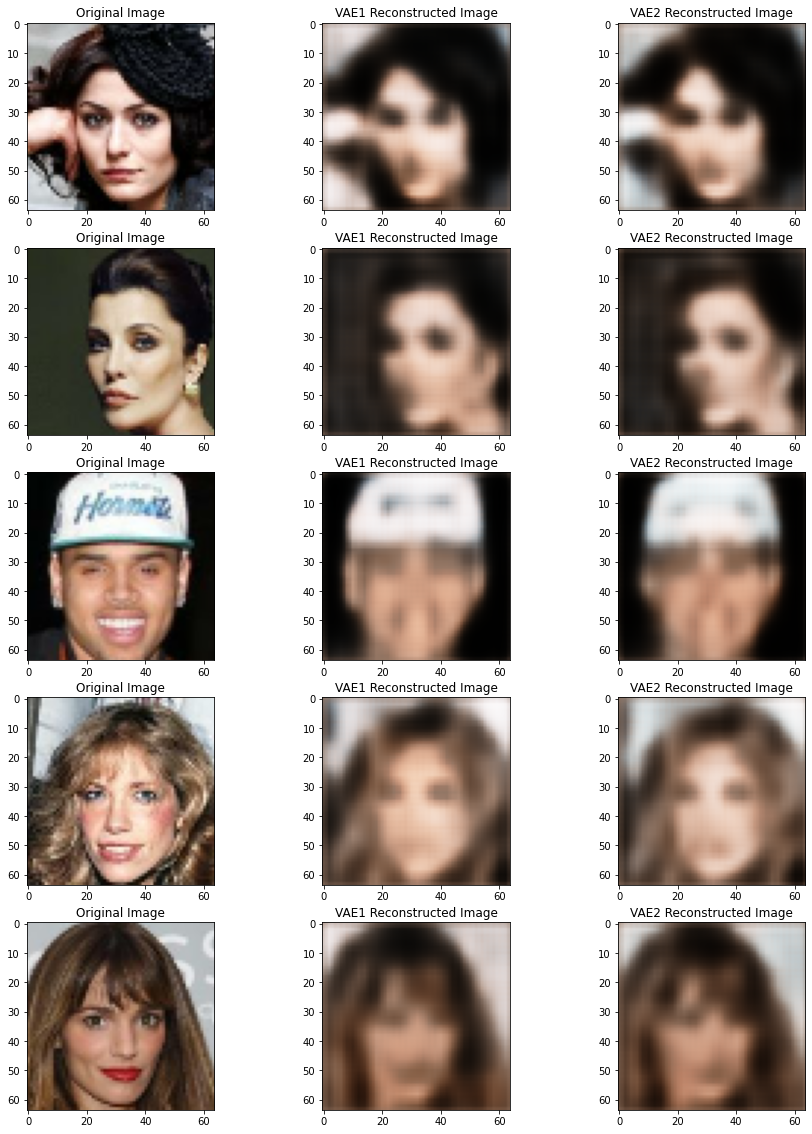

In [25]:
# 3.4
# your code here
# 2.6
fig, ax = plt.subplots(5,3,figsize=(15,20))
test_pics = val_ds.take(1)
for pic in test_pics:
    (image, image2) = pic
    vae1_predicted = VAE1.predict(image)
    vae2_predicted = VAE2.predict(image)
    for i in range(5):
        ax[i,0].imshow(image[i,:,:])
        ax[i,0].set_title("Original Image")
        ax[i,1].imshow(vae1_predicted[i,:,:])
        ax[i,1].set_title("VAE1 Reconstructed Image")
        ax[i,2].imshow(vae2_predicted[i,:,:])
        ax[i,2].set_title("VAE2 Reconstructed Image")


**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

In [26]:
# Extracing from bottleneck layer
import seaborn as sns

bottleneck_VAE1 = VAE1.layers[5].output
bottleneck_VAE2 = VAE2.layers[5].output

bottleneck_VAE1_model = tf.keras.Model(inputs=VAE1.layers[0].input, outputs=bottleneck_VAE1)

bottleneck_VAE2_model = tf.keras.Model(inputs = VAE2.layers[0].input, outputs=bottleneck_VAE2)

# pca_images = None
labels = []
pca_images = None
for image_group in val_cond_ds.take(32):
    ((image,attributes), image2) = image_group
    bald = attributes[:,1]
    goatee=attributes[:,0]
    for i in range (image.shape[0]):
        labels.append(int(np.sum((2*goatee[i].numpy(), bald[i].numpy()))))
    if pca_images is None:
        pca_images = image
    else:
        pca_images = np.append(pca_images, image, axis=0)
        
bottleneck_output_VAE1 = bottleneck_VAE1_model.predict(pca_images)
bottleneck_output_VAE2 = bottleneck_VAE2_model.predict(pca_images)



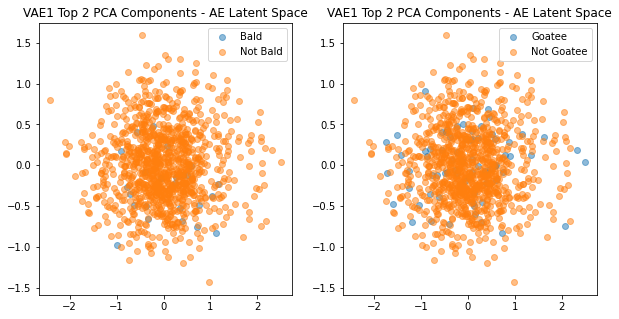

In [27]:
# 3.5
# your code here
labels = np.array(labels)
flattened_output = bottleneck_output_VAE1.reshape(bottleneck_output_VAE1.shape[0], -1) 
num_components = 2
pca = PCA(n_components=num_components).fit_transform(flattened_output)

fig, ax = plt.subplots(1,2, figsize=(10,5))
none = np.argwhere(labels==0)
bald = np.argwhere(labels==1)
goatee = np.argwhere(labels==2)
both = np.argwhere(labels==3)
all_bald = np.append(bald,both)
not_bald = np.append(goatee, none)
all_goatee = np.append(goatee,both)
not_goatee = np.append(bald, none)
ax[0].scatter(x=pca[all_bald,0], y=pca[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=pca[not_bald,0], y=pca[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("VAE1 Top 2 PCA Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=pca[all_goatee,0], y=pca[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=pca[not_goatee,0], y=pca[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("VAE1 Top 2 PCA Components - AE Latent Space")
ax[1].legend()


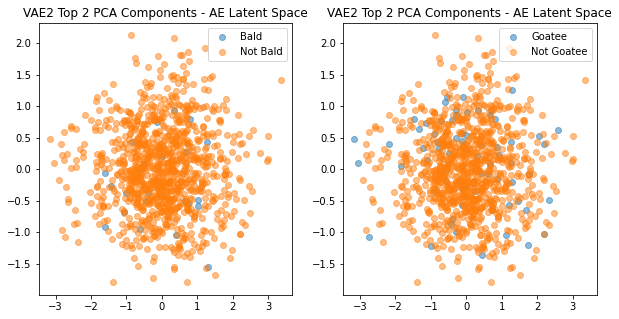

In [28]:
flattened_output = bottleneck_output_VAE2.reshape(bottleneck_output_VAE2.shape[0], -1) 
num_components = 2
pca = PCA(n_components=num_components).fit_transform(flattened_output)

fig, ax = plt.subplots(1,2, figsize=(10,5))
none = np.argwhere(labels==0)
bald = np.argwhere(labels==1)
goatee = np.argwhere(labels==2)
both = np.argwhere(labels==3)
all_bald = np.append(bald,both)
not_bald = np.append(goatee, none)
all_goatee = np.append(goatee,both)
not_goatee = np.append(bald, none)
ax[0].scatter(x=pca[all_bald,0], y=pca[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=pca[not_bald,0], y=pca[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("VAE2 Top 2 PCA Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=pca[all_goatee,0], y=pca[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=pca[not_goatee,0], y=pca[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("VAE2 Top 2 PCA Components - AE Latent Space")
ax[1].legend()


**Explanation of PCA visualization:** 

Again, while I don't see any patterns or clustering about my attributes, I do now see that there is a clear central cluster of "people" and then outliers, who perhaps exhibit features that are not common to the standard person. 

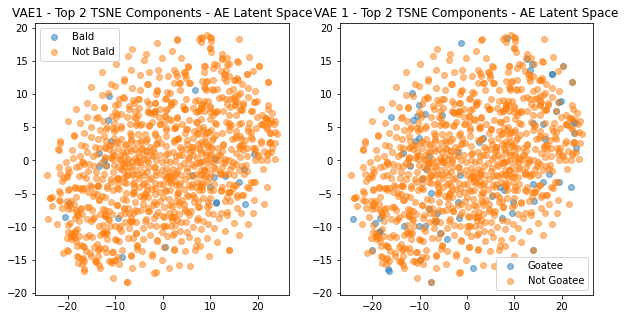

In [29]:
# 3.5
# your code here
# 2.7 (t-SNE visualization)
# your code here
num_components = 2
flattened_output = bottleneck_output_VAE1.reshape(bottleneck_output_VAE1.shape[0], -1) 

tsne = X_embedded = TSNE(n_components=num_components).fit_transform(flattened_output)
fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].scatter(x=tsne[all_bald,0], y=tsne[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=tsne[not_bald,0], y=tsne[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("VAE1 - Top 2 TSNE Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=tsne[all_goatee,0], y=tsne[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=tsne[not_goatee,0], y=tsne[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("VAE 1 - Top 2 TSNE Components - AE Latent Space")

ax[1].legend()



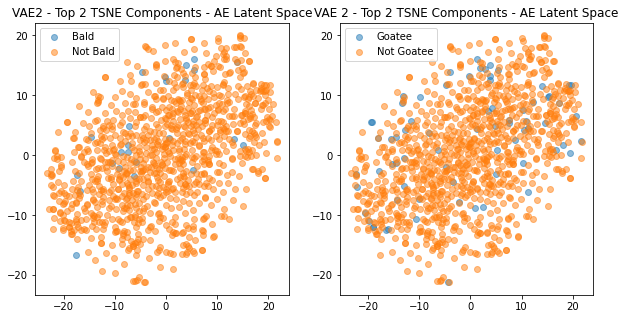

In [30]:
# 3.5
# your code here
# 2.7 (t-SNE visualization)
# your code here
num_components = 2
flattened_output = bottleneck_output_VAE2.reshape(bottleneck_output_VAE2.shape[0], -1) 

tsne = X_embedded = TSNE(n_components=num_components).fit_transform(flattened_output)
fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].scatter(x=tsne[all_bald,0], y=tsne[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=tsne[not_bald,0], y=tsne[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("VAE2 - Top 2 TSNE Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=tsne[all_goatee,0], y=tsne[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=tsne[not_goatee,0], y=tsne[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("VAE 2 - Top 2 TSNE Components - AE Latent Space")

ax[1].legend()



**Explanation of t-SNE decomposition:** 

TSNE demonstrates a primary and secondary axis which explains the variance in the data. However, again, my attributes do not exhibit any specific clustering. However, it should be noted that there are a number of patches of high density in the scatter plot. Perhaps these clusters correspond to similar looking people.

MY VAE2 shows less scatter in the clustering

<div class='exercise'> <b> Question 4: Set-up a Conditional VAE. [20 points] </b> </div>

Conditional VAEs are similar to standard VAEs were you incorporate an input's label/information into the latent space. When the model is trained in this form, the model learns to distinguish between these features. For example, you can select features on latent space manually, and explore the space of representations in an explicit manner. We point you to [one](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/) and [two](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) short tutorials on conditional VAEs. Additionally, you may be interested in reading the [original paper](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf), or a [continuation paper](https://papers.nips.cc/paper/7880-learning-latent-subspaces-in-variational-autoencoders.pdf). 

In this exercise you are going to build a conditional VAE, and reconstruct images by altering their attributes. For example, pick a set of 'not smiling men' and transform them by changing the label conditions such as 'smile' or 'gender' in latent space. You can choose whatever attributes you want, as long as the reconstructed latent space shows reasonable success when changing the attribute labels.

Follow this set of instructions:

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

**4.2** Train the model using the data generator you completed in Question 1.2 (use mean squared error loss and an optimizer of your choice). Print a summary of your model.

**We recommend saving your trained models**.

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

For example, if your choice of attributes where 'Male' and 'Smiling', you should reconstruct these images with all possible attribute combinations.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

## Answers

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

In [31]:
# 4.1
# your code here
input_image = tf.keras.layers.Input(shape=(input_size))
input_attributes = tf.keras.layers.Input(shape=(2,))
encoder = ConvEncoder(name="Encoder", input_shape=input_size)(input_image)
flatten = tf.keras.layers.Flatten()(encoder)
concat1 = tf.keras.layers.Concatenate()([flatten, input_attributes])
dense_mean = tf.keras.layers.Dense(128, activation='linear')(concat1)
dense_variance = tf.keras.layers.Dense(128, activation='linear')(concat1)
sampling = Sampling()((dense_mean, dense_variance))
concat2 = tf.keras.layers.Concatenate()([sampling, input_attributes])
dense_relu = tf.keras.layers.Dense(1024, activation='relu')(concat2)
reshape = tf.keras.layers.Reshape((4, 4, 64), input_shape=(1024,))(dense_relu)
deconv = ConvDecoder(name="Decoder", input_shape=(4, 4, 64))(reshape)

CVAE = tf.keras.Model(inputs=[input_image,input_attributes], outputs = deconv)
CVAE.compile(optimizer='Adam', loss='mean_squared_error') 

CVAE.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (ConvEncoder)           (None, 4, 4, 64)     70448       input_4[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1024)         0           Encoder[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
____________________________________________________________________________________________

**4.2** Train the model using the generator you completed in Q1.3. Print a summary of your model.
**We recommend saving your trained models**.

In [32]:
# 4.2
# your code here
CVAE.fit(
    train_cond_ds,
    epochs=5, validation_data=val_cond_ds)

Epoch 1/5
     76/Unknown - 4s 56ms/step - loss: 0.0738

KeyboardInterrupt: 

In [ ]:
CVAE.save_weights('CVAE')


In [33]:
CVAE.load_weights('CVAE')


**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

(32, 64, 64, 3)


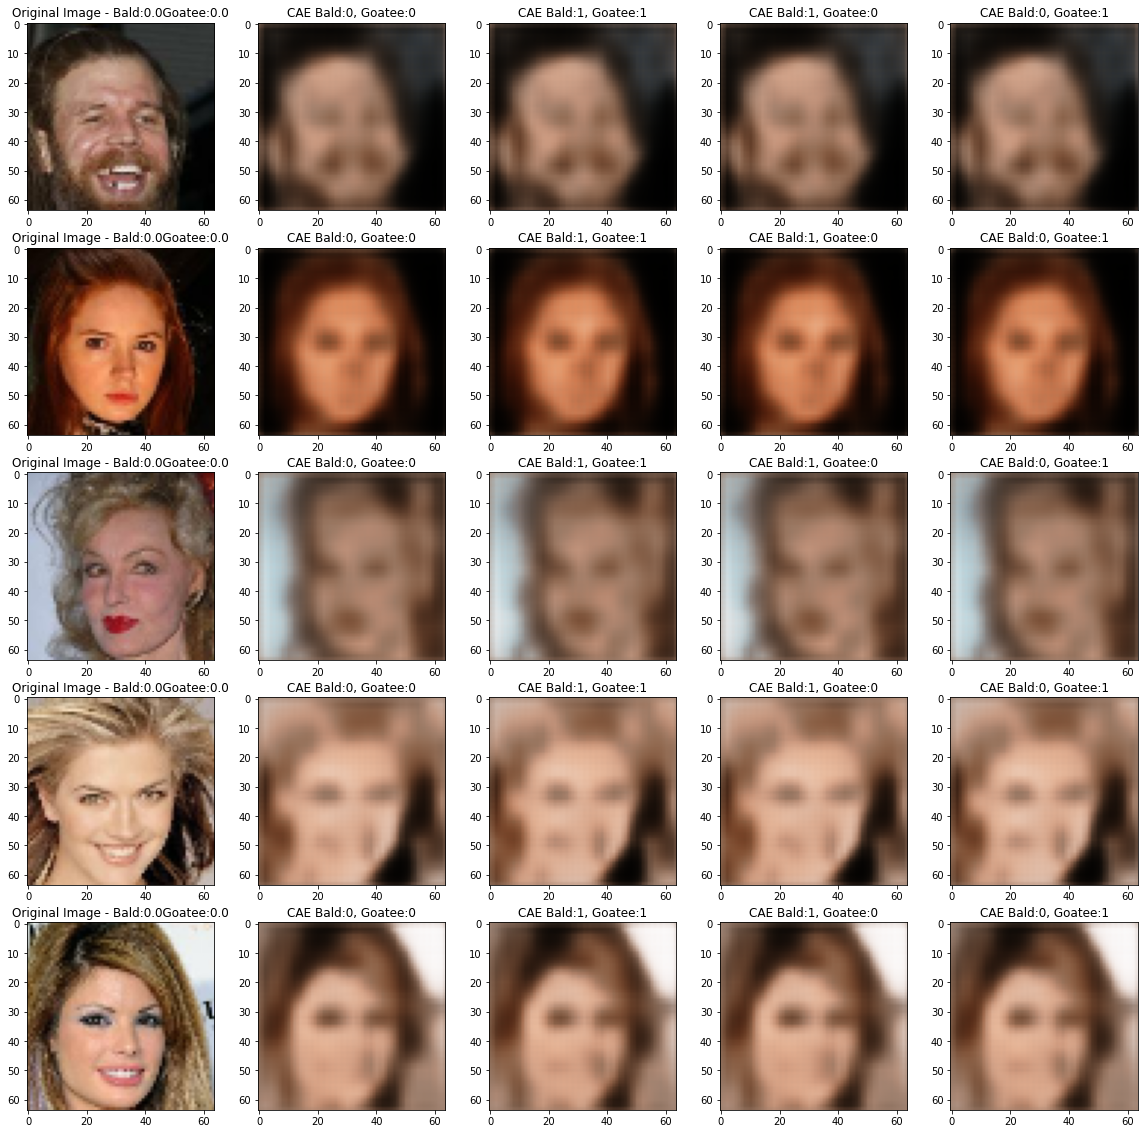

In [34]:
# 4.3
# Example case: select 5 images of men, not smiling; reconstruct with smiling and no smiling, and as smiling/no-smiling women.
# your code here
fig, ax = plt.subplots(5,5,figsize=(20,20))
test_pics = val_cond_ds.take(1)
for pic in test_pics:
    ((image,attributes), image2) = test_img
    bald = attributes[:,1]
    goatee=attributes[:,0]
    none_array = np.zeros((32,2))
    both_array = np.ones((32,2))
    bald_array = np.append(np.zeros((32,1)), np.ones((32,1)), axis=1)
    goatee_array = np.append(np.ones((32,1)), np.zeros((32,1)), axis=1)
    none_pred = CVAE.predict((image,none_array))
    both_pred =  CVAE.predict((image,both_array))
    bald_pred = CVAE.predict((image,bald_array))
    goatee_pred = CVAE.predict((image,goatee_array))
    print(np.shape(image.numpy()))
    
    for i in range(5):
        CVAE.predict((image,none_array))
        ax[i,0].set_title("Original Image - Bald:"+str(bald[i].numpy())+"Goatee:"+str(goatee[i].numpy()))
        ax[i,0].imshow(image[i,:,:])
        ax[i,1].set_title("CAE Bald:0, Goatee:0")
        ax[i,1].imshow(none_pred[i,:,:])
        ax[i,2].set_title("CAE Bald:1, Goatee:1")
        ax[i,2].imshow(both_pred[i,:,:])
        ax[i,3].set_title("CAE Bald:1, Goatee:0")
        ax[i,3].imshow(bald_pred[i,:,:])
        ax[i,4].set_title("CAE Bald:0, Goatee:1")
        ax[i,4].imshow(goatee_pred[i,:,:])


In [35]:
np.append(np.zeros((32,1)), np.ones((32,1)), axis=1).shape

(32, 2)

While I don't necessarily get the conclusive results I hoped for, I do see that when i set Goatee = 1 for  people without goatee's, there is a darker area around their mouths, which demonstrates the impact of this attribute on my model. However, as i noticed from the PCA plots earlier, Bald and Goatee aren't the best attributes with regards to predicting the overall appearance of human, and perhaps something like gender would be more effective. Moreover, I would imagine that my model would be further improved by adding all of the attributes as opposed to just these two. This would come at a computational cost, however.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

In [36]:
# 4.4
# Extracing from bottleneck layer
import seaborn as sns

bottleneck_CVAE = CVAE.layers[7].output

bottleneck_CVAE_model = tf.keras.Model(inputs=[CVAE.layers[0].input,CVAE.layers[3].input], outputs=bottleneck_CVAE)


# pca_images = None
labels = []
pca_images = None
pca_attributes = None
for image_group in val_cond_ds.take(32):
    ((image,attributes), image2) = image_group
    bald = attributes[:,1]
    goatee=attributes[:,0]
    for i in range (image.shape[0]):
        labels.append(int(np.sum((2*goatee[i].numpy(), bald[i].numpy()))))
    if pca_images is None:
        pca_images = image
        pca_attributes = attributes
    else:
        pca_images = np.append(pca_images, image, axis=0)
        pca_attributes = np.append(pca_attributes, attributes, axis=0)
        
bottleneck_output_CVAE = bottleneck_CVAE_model.predict((pca_images, pca_attributes))

labels = np.array(labels)


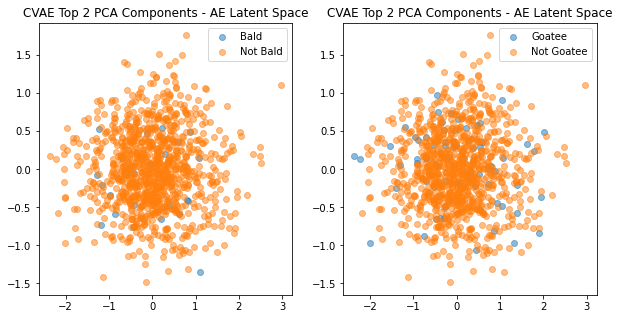

In [37]:
flattened_output = bottleneck_output_CVAE.reshape(bottleneck_output_CVAE.shape[0], -1) 
num_components = 2
pca = PCA(n_components=num_components).fit_transform(flattened_output)

fig, ax = plt.subplots(1,2, figsize=(10,5))
none = np.argwhere(labels==0)
bald = np.argwhere(labels==1)
goatee = np.argwhere(labels==2)
both = np.argwhere(labels==3)
all_bald = np.append(bald,both)
not_bald = np.append(goatee, none)
all_goatee = np.append(goatee,both)
not_goatee = np.append(bald, none)
ax[0].scatter(x=pca[all_bald,0], y=pca[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=pca[not_bald,0], y=pca[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("CVAE Top 2 PCA Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=pca[all_goatee,0], y=pca[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=pca[not_goatee,0], y=pca[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("CVAE Top 2 PCA Components - AE Latent Space")
ax[1].legend()


As with the VAEs above, I see that there is a distinct cluster in the middle, with a couple patterns around it. This center cluster thus represents the majority of humans represented in latent space, while the outliers are humans with stranger traits and physical characteristics.
Again, the goatee and bald attributes do not distribute great clustering or show any pattern.

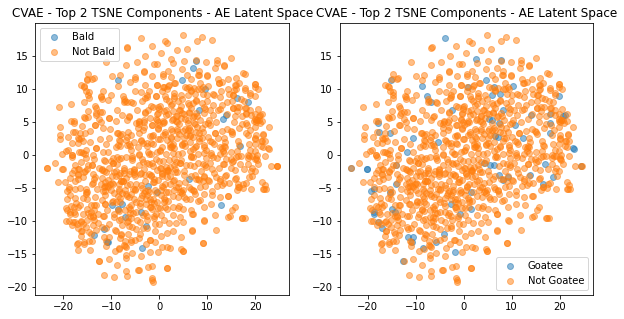

In [38]:
# 4.4
# your code here
num_components = 2
flattened_output = bottleneck_output_CVAE.reshape(bottleneck_output_CVAE.shape[0], -1) 

tsne = X_embedded = TSNE(n_components=num_components).fit_transform(flattened_output)
fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].scatter(x=tsne[all_bald,0], y=tsne[all_bald,1], alpha=0.5,label="Bald")
ax[0].scatter(x=tsne[not_bald,0], y=tsne[not_bald,1], alpha=0.5,label="Not Bald")
ax[0].set_title("CVAE - Top 2 TSNE Components - AE Latent Space")
ax[0].legend()
ax[1].scatter(x=tsne[all_goatee,0], y=tsne[all_goatee,1], alpha=0.5,label="Goatee")
ax[1].scatter(x=tsne[not_goatee,0], y=tsne[not_goatee,1], alpha=0.5,label="Not Goatee")
ax[1].set_title("CVAE - Top 2 TSNE Components - AE Latent Space")

ax[1].legend()

A distinct two axes for the variance are displayed than with the VAEs, with the majority of the variance going bottom left to top right. Again, i see little clusters of a number of pictures, which perhaps are pictures of the same person or similar looking people.

---

<div class='exercise'> <b> Question 5: Generative Adversarial Networks. [20 points] </b> </div>

For the final exercise we are going to create a standard GAN composed of a generator, and a discriminator. GANs are tricky to train, so we encourage you to follow the given instructions when training your models. However, feel completely free to explore and present other layer architectures if they present better results.

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.

## Answers

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

In [39]:
#@title
noise_dim = 128
z_dim = noise_dim

# (a) GENERATOR
input_noise = tf.keras.layers.Input(shape=(noise_dim))
dense_relu = tf.keras.layers.Dense(1024, use_bias=False)(input_noise)
reshape = tf.keras.layers.Reshape((4, 4, 64))(dense_relu)
deConv0 = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu, use_bias=False)(reshape)
deConv1 = tf.keras.layers.Conv2DTranspose(18, (5,5), use_bias=False, padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu)(deConv0)
deConv2 = tf.keras.layers.Conv2DTranspose(9, (5,5), use_bias=False, padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu)(deConv1)
deConv3 = tf.keras.layers.Conv2DTranspose(3, (5,5), use_bias=False,padding='same', strides=(2,2),
                       activation='sigmoid')(deConv2)
g = tf.keras.Model(inputs = input_noise,outputs=deConv3)
g.summary()


g.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              131072    
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 32)          51200     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 18)        14400     
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 32, 32, 9)         4050      
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 64, 64, 3)         675 

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

In [40]:
# (b) DISCRIMINATOR
input_layer = tf.keras.layers.Input(shape=(64,64,3))
conv1 = tf.keras.layers.Conv2D(9, (4,4), padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu)(input_layer)
conv2 = tf.keras.layers.Conv2D(18, (4,4), padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu)(conv1)
conv3 = tf.keras.layers.Conv2D(32, (4,4), padding='same', strides=(2,2),
                       activation=tf.nn.leaky_relu)(conv2)
flatten = tf.keras.layers.Flatten()(conv3)
dense_1 = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


d = tf.keras.Model(input_layer, dense_1)
d.compile(loss='binary_crossentropy', optimizer='adam')
d.summary()



Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 9)         441       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 18)        2610      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049      
Total params: 14,348
Trainable params: 14,348
Non-trainable params: 0
_______________________________________________________

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.


In [41]:
d.trainable = False
inputs = tf.keras.layers.Input(shape=(z_dim,))
hidden = g(inputs)
output = d(hidden)
gan = tf.keras.Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

In [42]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    print(np.shape(generated_images))
    generated_images = generated_images.reshape(n_ex, 64, 64,3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i,:,:,:], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    


In [45]:
from tqdm import tqdm_notebook
losses = {"D":[], "G":[]}

def train(epochs=10, plt_frq=1, BATCH_SIZE=32):
    batchCount = 5000
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in range(1, epochs+1):
        if e == 1 or e%plt_frq == 0:
            print(
                '-'*15, 'Epoch %d' % e, '-'*15)
            
        for _ in tqdm_notebook(range(batchCount)):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = train_ds.take(8)
            for batch in image_batch:
                (image,image2) = batch
            # Create noise vectors for the generator
                noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

                # Generate the images from the noise
                generated_images = g.predict(noise)
                X = np.concatenate((image, generated_images))
                # Create labels
                y = np.zeros(2*BATCH_SIZE)
                y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

                # Train discriminator on generated images
                d.trainable = True
                d_loss = d.train_on_batch(X, y)

                # Train generator
                noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
                y2 = np.ones(BATCH_SIZE)
                d.trainable = False
                g_loss = gan.train_on_batch(noise, y2)
                losses["D"].append(d_loss)
                losses["G"].append(g_loss)


        # Only store losses from final
        
        # Update the plots
#         if e == 1 or e%plt_frq == 0:
#             plot_generated()
#     plot_loss(losses)

In [ ]:
train(epochs=10, plt_frq=40, BATCH_SIZE=32)

Epochs: 10
Batch size: 32
Batches per epoch: 5000
--------------- Epoch 1 ---------------


In [ ]:
plot_generated()

*your answer here*

---